In [146]:
import os
import matplotlib.pyplot as plt
import cv2
from glob import glob
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Input, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

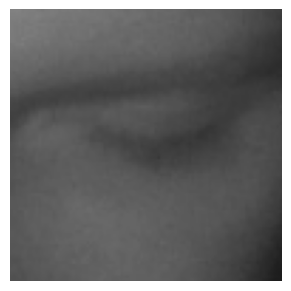

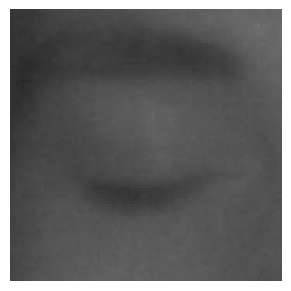

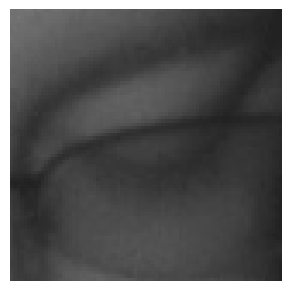

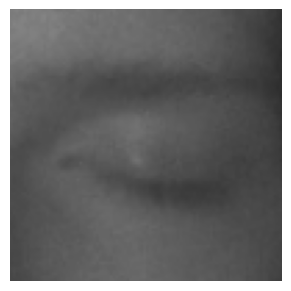

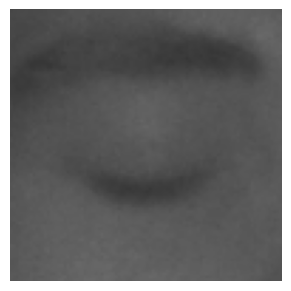

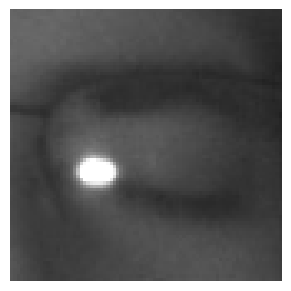

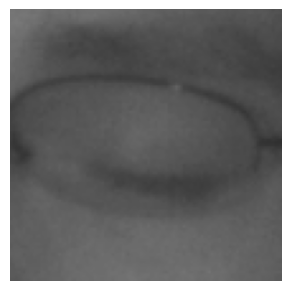

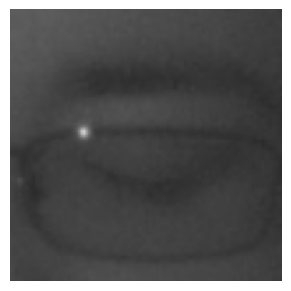

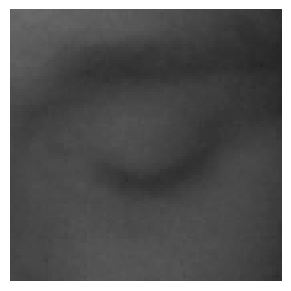

In [150]:
images = glob("images/closed_eye/**")
for i in range(1,10):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(3,3,i)
    img = cv2.imread(image)
    plt.imshow(img)
    plt.axis('off')

In [151]:
dataset_path1 = "images/closed_eye"
dataset_path2 = "images/open_eye"
all_files1 = [os.path.join(dataset_path1,filename) for filename in os.listdir(dataset_path1) if filename.endswith('.png')]
all_files2 = [os.path.join(dataset_path2,filename) for filename in os.listdir(dataset_path2) if filename.endswith('.png')]
df1 = pd.DataFrame({"Image":all_files1, "Class":str(0)})
df2 = pd.DataFrame({"Image":all_files2, "Class":str(1)})
df3 = pd.concat([df1,df2], ignore_index=True)
train_df, test_df = train_test_split(df3, train_size=0.8, random_state=42)
print(len(train_df))
print(len(test_df))

38400
9600


In [152]:
train_df.head(5)

,Image,Class
596,images/closed_eye\s0001_00609_0_0_0_0_0_01.png,0
30136,images/open_eye\s0013_03199_0_0_1_0_0_01.png,1
8339,images/closed_eye\s0011_00197_0_0_0_0_0_01.png,0
12824,images/closed_eye\s0012_03572_0_1_0_2_1_01.png,0
22894,images/closed_eye\s0019_02046_0_0_0_0_1_01.png,0


In [161]:
import shutil
from tqdm import tqdm
from PIL import Image

base_directory = "images"
train_directory = os.path.join(base_directory, "train")
test_directory = os.path.join(base_directory, "test")

os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

def move_images_to_folders(data_frame, base_folder):
    for index, row in tqdm(data_frame.iterrows(), total=data_frame.shape[0]):
        image_path = row['Image']
        image_class = row['Class']
        image = Image.open(image_path)
        class_folder = os.path.join(base_folder, str(image_class))
        os.makedirs(class_folder, exist_ok=True)
        image_filename = os.path.basename(image_path)
        destination_path = os.path.join(class_folder, image_filename)
        image.save(destination_path)
        
move_images_to_folders(train_df, train_directory)
move_images_to_folders(test_df, test_directory)

100%|█████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:36<00:00, 263.25it/s]


In [219]:
datagen_train = ImageDataGenerator(validation_split=0.1,
                                  horizontal_flip=True)
training_generator = datagen_train.flow_from_directory("images/train",
                                                        target_size = (48,48),
                                                        batch_size = 64,
                                                        color_mode = 'grayscale',
                                                        class_mode = 'binary',
                                                        shuffle = True,
                                                        subset = 'training')
validation_generator = datagen_train.flow_from_directory("images/train",
                                                         target_size = (48,48),
                                                         batch_size = 64,
                                                         color_mode = 'grayscale',
                                                         class_mode = 'binary',
                                                         shuffle = True,
                                                         subset = 'validation')
datagen_test = ImageDataGenerator()
testing_generator = datagen_test.flow_from_directory("images/test",
                                                        target_size = (48,48),
                                                        batch_size = 64,
                                                        color_mode = 'grayscale',
                                                        class_mode = 'binary',
                                                        shuffle = True)

Found 34561 images belonging to 2 classes.
Found 3839 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [220]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)
    return x

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    return x

def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(conv_1, 64, (5,5))
    conv_3 = Convolution(conv_2, 128, (3,3))
    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(1, activation = "sigmoid")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    opt = Adam(learning_rate=0.001)
    model.compile(loss = ["binary_crossentropy"], optimizer = opt, metrics = ["accuracy"])
    return model

In [221]:
model = model_fer((48,48,1))
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_52 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_52 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_52 (Dropout)        (None, 24, 24, 32)        0  

In [222]:
batch_size = 64
checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_loss", save_weights_only = True, mode = "min", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

In [223]:
history = model.fit(
x = training_generator,
steps_per_epoch = training_generator.n//training_generator.batch_size,
epochs = 15,
validation_data = validation_generator,
validation_steps = validation_generator.n//validation_generator.batch_size,
callbacks = callbacks)

Epoch 1/15
540/540 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9532
Epoch 1: saving model to model_weights.h5
540/540 [==============================] - 186s 338ms/step - loss: 0.1223 - accuracy: 0.9532 - val_loss: 1.3380 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 2/15
540/540 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9823
Epoch 2: saving model to model_weights.h5
540/540 [==============================] - 159s 294ms/step - loss: 0.0496 - accuracy: 0.9823 - val_loss: 0.4162 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 3/15
540/540 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9861
Epoch 3: saving model to model_weights.h5
540/540 [==============================] - 159s 295ms/step - loss: 0.0410 - accuracy: 0.9861 - val_loss: 0.5337 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 4/15
540/540 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9892
Epoch 4: saving model to model_weights.h5
540/

In [224]:
model.evaluate(testing_generator)

150/150 [==============================] - 14s 91ms/step - loss: 0.0935 - accuracy: 0.9772


[0.0934760570526123, 0.9771875143051147]

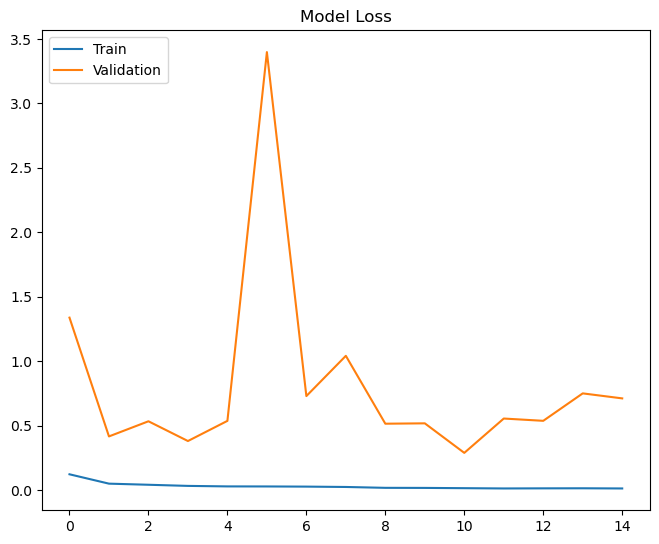

In [225]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom = 0.0, right = 0.95, left=0.0, hspace=0.25, wspace=0.35)

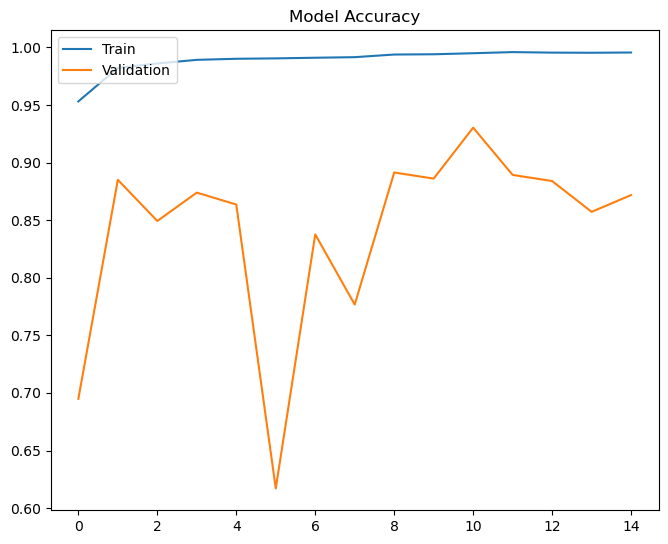

In [226]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom = 0.0, right = 0.95, left=0.0, hspace=0.25, wspace=0.35)

In [231]:
model_json = model.to_json()
with open('model_a.json', "w") as json_file:
    json_file.write(model_json)